In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [7]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [36]:
# For Saliency

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

def arith(n):
    return int(n*(n+1)/2)

topRMSE = np.zeros((10,10)) # Group(split), num features(N)

for j in range(10):
    
    class GCN(nn.Module):
        def __init__(self, nTgt, dp=0.5):
            super(GCN, self).__init__()
            self.gcn = []
            for i in range(2*nTgt):
                self.gcn.append(DenseGCNConv(1*j+1,20).float().cuda())
                self.gcn.append(DenseGCNConv(20,1).float().cuda())
            self.gcn = nn.ModuleList(self.gcn)
            self.dp = nn.Dropout(p=dp)

        def forward(self, x):
            e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
            x = self.dp(x)
            res = []
            for i in range(x.shape[1]):
                y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
                y = self.gcn[2*i+1](y,e).squeeze()
                res.append(y)
            return res

    class MLP(nn.Module):
        def __init__(self, nTgt, dp=0.5):
            super(MLP, self).__init__()
            self.lin = []
            for i in range(2*nTgt):
                self.lin.append(nn.Linear(arith(263),40).float().cuda())
                self.lin.append(nn.Linear(40,1).float().cuda())
            self.lin = nn.ModuleList(self.lin)
            self.dp = nn.Dropout(p=dp)

        def forward(self, x):
            x = self.dp(x)
            res = []
            for i in range(x.shape[1]):
                y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
                y = self.lin[2*i+1](y).squeeze()
                res.append(y)
            return res

    def validate(model, X, y, testIdcs):
        model.eval()
        with torch.no_grad():
            res = model(X)
            avg = torch.mean(torch.stack(res), dim=0)
            if res[0].dim() == 1:
                loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
            else:
                corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
        model.train()
        return loss

    ceLoss = torch.nn.CrossEntropyLoss()
    mseLoss = torch.nn.MSELoss()
    nEpochs = 10000
    pPeriod = 500
    thresh = 100

    
    # para = [nback_pp_t, emoid_pp_t]
    rmse = []
#     finalRes = 10*[None]


    t = time.time()
    for i in range(10):
        
        para = [nback_p_t[:,nidcs[i][-1*j-1:]], emoid_p_t[:,eidcs[i][-1*j-1:]]]
        X = torch.stack(para, dim=1)
        
        gcn0 = GCN(2, 0) #Guys(X, 2, 2, 0.5)
        params = list(gcn0.parameters())
        optim = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-3) # 2e-4

        trainIdcs = groups[i][0][0:496]
        validIdcs = groups[i][0]
        testIdcs = groups[i][1]

        Xt = X[trainIdcs]
        Xv = X[validIdcs]
        Xt.requires_grad_(True)

        trainLoss = []
        validLoss = []

        val = wrt_t

        for epoch in range(nEpochs):
            Xt.grad = None
            optim.zero_grad()
            res = gcn0(Xt)
            avg = torch.mean(torch.stack(res), dim=0)
            loss0 = 0
            for r in res + [avg]:
                loss0 += mseLoss(r, val[trainIdcs])/(len(res)+1)
            loss = torch.stack([loss0])
            torch.sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
                print(f'epoch {epoch} loss={(float(loss0))}')
                lossV = validate(gcn0, Xv, val[validIdcs], np.arange(496,len(validIdcs)))
                if len(validLoss) == 0 or lossV < min(validLoss):
                    print(f'New best validation epoch {epoch} loss={lossV}')
                    torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
#                     finalRes[i] = Xt.grad.detach()
                validLoss.append(lossV)
                if torch.all(loss[0:3] < thresh):
                    print('Early stopping')
                    break

        print('Finished training')

        gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
        loss0 = validate(gcn0, X, val, testIdcs)

#         rmse.append((float(loss0)))

        topRMSE[i,j] = float(loss0)

        print(f'{j} {i} {topRMSE[i,j]}')
#         print(rmse[-1])

    print(time.time()-t)

epoch 0 loss=10911.5712890625
New best validation epoch 0 loss=100.73995208740234
epoch 500 loss=8910.107421875
New best validation epoch 500 loss=90.60462188720703
epoch 1000 loss=5142.34423828125
New best validation epoch 1000 loss=67.7396011352539
epoch 1500 loss=2006.8848876953125
New best validation epoch 1500 loss=40.35028839111328
epoch 2000 loss=593.1707763671875
New best validation epoch 2000 loss=18.956430435180664
epoch 2500 loss=290.5791015625
New best validation epoch 2500 loss=11.722850799560547
epoch 3000 loss=264.06170654296875
New best validation epoch 3000 loss=11.711315155029297
epoch 3500 loss=262.9385681152344
epoch 4000 loss=262.77838134765625
epoch 4500 loss=262.63055419921875
epoch 5000 loss=262.47979736328125
epoch 5500 loss=262.33367919921875
epoch 6000 loss=262.19952392578125
epoch 6500 loss=262.08251953125
epoch 7000 loss=261.98431396484375
epoch 7500 loss=261.903564453125
epoch 8000 loss=261.8377685546875
epoch 8500 loss=261.785400390625
epoch 9000 loss=261

epoch 7000 loss=255.21368408203125
New best validation epoch 7000 loss=13.186939239501953
epoch 7500 loss=253.40664672851562
New best validation epoch 7500 loss=13.10952091217041
epoch 8000 loss=252.03831481933594
New best validation epoch 8000 loss=13.047811508178711
epoch 8500 loss=251.06057739257812
New best validation epoch 8500 loss=13.001845359802246
epoch 9000 loss=250.40249633789062
New best validation epoch 9000 loss=12.970611572265625
epoch 9500 loss=249.98550415039062
New best validation epoch 9500 loss=12.952101707458496
epoch 9999 loss=249.73876953125
New best validation epoch 9999 loss=12.943428039550781
Finished training
0 6 16.932754516601562
epoch 0 loss=10842.5947265625
New best validation epoch 0 loss=100.92866516113281
epoch 500 loss=9242.33984375
New best validation epoch 500 loss=92.90159606933594
epoch 1000 loss=5917.154296875
New best validation epoch 1000 loss=73.6116714477539
epoch 1500 loss=2765.35595703125
New best validation epoch 1500 loss=49.0637435913085

epoch 6000 loss=262.6534729003906
epoch 6500 loss=262.1379699707031
epoch 7000 loss=261.80584716796875
epoch 7500 loss=261.5745544433594
epoch 8000 loss=261.3857727050781
New best validation epoch 8000 loss=12.161324501037598
epoch 8500 loss=261.2164611816406
New best validation epoch 8500 loss=12.153346061706543
epoch 9000 loss=261.06689453125
New best validation epoch 9000 loss=12.14741325378418
epoch 9500 loss=260.94635009765625
New best validation epoch 9500 loss=12.145416259765625
epoch 9999 loss=260.85614013671875
New best validation epoch 9999 loss=12.144153594970703
Finished training
1 2 13.341999053955078
epoch 0 loss=10829.638671875
New best validation epoch 0 loss=100.8618392944336
epoch 500 loss=8749.791015625
New best validation epoch 500 loss=90.20782470703125
epoch 1000 loss=4663.4716796875
New best validation epoch 1000 loss=64.60232543945312
epoch 1500 loss=1579.915771484375
New best validation epoch 1500 loss=35.26371765136719
epoch 2000 loss=454.8354187011719
New bes

epoch 9999 loss=242.9277801513672
New best validation epoch 9999 loss=11.960188865661621
Finished training
1 7 16.385011672973633
epoch 0 loss=10850.37109375
New best validation epoch 0 loss=100.26175689697266
epoch 500 loss=9057.6533203125
New best validation epoch 500 loss=91.17667388916016
epoch 1000 loss=5231.85009765625
New best validation epoch 1000 loss=68.09689331054688
epoch 1500 loss=1950.7606201171875
New best validation epoch 1500 loss=39.43760681152344
epoch 2000 loss=563.7218627929688
New best validation epoch 2000 loss=18.21980094909668
epoch 2500 loss=303.7044982910156
New best validation epoch 2500 loss=12.487032890319824
epoch 3000 loss=283.0535583496094
epoch 3500 loss=278.338623046875
epoch 4000 loss=273.7140197753906
epoch 4500 loss=269.0622863769531
New best validation epoch 4500 loss=12.426115036010742
epoch 5000 loss=264.6051940917969
New best validation epoch 5000 loss=12.305011749267578
epoch 5500 loss=260.54290771484375
New best validation epoch 5500 loss=12.

epoch 1500 loss=1995.205078125
New best validation epoch 1500 loss=40.589908599853516
epoch 2000 loss=604.4342651367188
New best validation epoch 2000 loss=19.415279388427734
epoch 2500 loss=319.1097106933594
New best validation epoch 2500 loss=12.515667915344238
epoch 3000 loss=292.7715148925781
New best validation epoch 3000 loss=12.321945190429688
epoch 3500 loss=286.92230224609375
New best validation epoch 3500 loss=12.311193466186523
epoch 4000 loss=281.45220947265625
New best validation epoch 4000 loss=12.20132827758789
epoch 4500 loss=276.0251770019531
New best validation epoch 4500 loss=12.08495807647705
epoch 5000 loss=270.86419677734375
New best validation epoch 5000 loss=11.979079246520996
epoch 5500 loss=266.0256652832031
New best validation epoch 5500 loss=11.884062767028809
epoch 6000 loss=261.5462646484375
New best validation epoch 6000 loss=11.805922508239746
epoch 6500 loss=257.62060546875
New best validation epoch 6500 loss=11.752222061157227
epoch 7000 loss=254.39788

epoch 3500 loss=301.01641845703125
epoch 4000 loss=291.94512939453125
New best validation epoch 4000 loss=12.696131706237793
epoch 4500 loss=282.8802185058594
New best validation epoch 4500 loss=12.534053802490234
epoch 5000 loss=274.23187255859375
New best validation epoch 5000 loss=12.380167007446289
epoch 5500 loss=266.37359619140625
New best validation epoch 5500 loss=12.243378639221191
epoch 6000 loss=259.580810546875
New best validation epoch 6000 loss=12.130044937133789
epoch 6500 loss=254.01353454589844
New best validation epoch 6500 loss=12.044217109680176
epoch 7000 loss=249.7162322998047
New best validation epoch 7000 loss=11.987381935119629
epoch 7500 loss=246.62603759765625
New best validation epoch 7500 loss=11.958218574523926
epoch 8000 loss=244.58670043945312
New best validation epoch 8000 loss=11.952666282653809
epoch 8500 loss=243.37298583984375
epoch 9000 loss=242.7321014404297
epoch 9500 loss=242.4346923828125
epoch 9999 loss=242.3134307861328
Finished training
2 8 

epoch 500 loss=8807.2421875
New best validation epoch 500 loss=90.5541000366211
epoch 1000 loss=4961.2373046875
New best validation epoch 1000 loss=66.85022735595703
epoch 1500 loss=1876.433837890625
New best validation epoch 1500 loss=38.991695404052734
epoch 2000 loss=580.8453979492188
New best validation epoch 2000 loss=18.49358558654785
epoch 2500 loss=325.1142578125
New best validation epoch 2500 loss=12.478020668029785
epoch 3000 loss=298.265625
New best validation epoch 3000 loss=12.354065895080566
epoch 3500 loss=291.37432861328125
New best validation epoch 3500 loss=12.319337844848633
epoch 4000 loss=285.18267822265625
New best validation epoch 4000 loss=12.189055442810059
epoch 4500 loss=279.010498046875
New best validation epoch 4500 loss=12.050032615661621
epoch 5000 loss=273.0706481933594
New best validation epoch 5000 loss=11.920819282531738
epoch 5500 loss=267.55792236328125
New best validation epoch 5500 loss=11.808682441711426
epoch 6000 loss=262.59954833984375
New bes

epoch 2000 loss=1209.8331298828125
New best validation epoch 2000 loss=28.82530403137207
epoch 2500 loss=504.7886657714844
New best validation epoch 2500 loss=15.626452445983887
epoch 3000 loss=367.6170654296875
New best validation epoch 3000 loss=13.140905380249023
epoch 3500 loss=345.40667724609375
epoch 4000 loss=332.7136535644531
epoch 4500 loss=319.9477844238281
New best validation epoch 4500 loss=12.946087837219238
epoch 5000 loss=307.1133728027344
New best validation epoch 5000 loss=12.730058670043945
epoch 5500 loss=294.69183349609375
New best validation epoch 5500 loss=12.522133827209473
epoch 6000 loss=283.13421630859375
New best validation epoch 6000 loss=12.333395004272461
epoch 6500 loss=272.80987548828125
New best validation epoch 6500 loss=12.173128128051758
epoch 7000 loss=263.9849853515625
New best validation epoch 7000 loss=12.048670768737793
epoch 7500 loss=256.8086242675781
New best validation epoch 7500 loss=11.964484214782715
epoch 8000 loss=251.3007354736328
New 

epoch 500 loss=9073.7578125
New best validation epoch 500 loss=91.975830078125
epoch 1000 loss=5292.578125
New best validation epoch 1000 loss=69.15008544921875
epoch 1500 loss=2158.3330078125
New best validation epoch 1500 loss=41.92542266845703
epoch 2000 loss=733.8973388671875
New best validation epoch 2000 loss=20.974964141845703
epoch 2500 loss=381.57049560546875
New best validation epoch 2500 loss=13.24805736541748
epoch 3000 loss=323.14111328125
New best validation epoch 3000 loss=12.502982139587402
epoch 3500 loss=308.9498291015625
New best validation epoch 3500 loss=12.389713287353516
epoch 4000 loss=298.80743408203125
New best validation epoch 4000 loss=12.202653884887695
epoch 4500 loss=289.12908935546875
New best validation epoch 4500 loss=12.00117015838623
epoch 5000 loss=280.13348388671875
New best validation epoch 5000 loss=11.814482688903809
epoch 5500 loss=272.1247253417969
New best validation epoch 5500 loss=11.654257774353027
epoch 6000 loss=265.2563171386719
New bes

epoch 500 loss=8787.0283203125
New best validation epoch 500 loss=89.63522338867188
epoch 1000 loss=4921.77734375
New best validation epoch 1000 loss=65.46544647216797
epoch 1500 loss=1889.71923828125
New best validation epoch 1500 loss=37.56737518310547
epoch 2000 loss=645.0722045898438
New best validation epoch 2000 loss=18.206777572631836
epoch 2500 loss=380.0815124511719
New best validation epoch 2500 loss=13.38484001159668
epoch 3000 loss=338.2433776855469
New best validation epoch 3000 loss=13.376163482666016
epoch 3500 loss=322.583740234375
New best validation epoch 3500 loss=13.26945972442627
epoch 4000 loss=307.90374755859375
New best validation epoch 4000 loss=12.985306739807129
epoch 4500 loss=291.3736572265625
New best validation epoch 4500 loss=12.598695755004883
epoch 5000 loss=275.8620300292969
New best validation epoch 5000 loss=12.258872032165527
epoch 5500 loss=262.67926025390625
New best validation epoch 5500 loss=11.9801607131958
epoch 6000 loss=252.17739868164062
N

epoch 9500 loss=240.4251708984375
epoch 9999 loss=239.4761962890625
Finished training
5 2 12.814908027648926
epoch 0 loss=10836.3349609375
New best validation epoch 0 loss=100.89532470703125
epoch 500 loss=8499.05078125
New best validation epoch 500 loss=88.8623275756836
epoch 1000 loss=4257.0029296875
New best validation epoch 1000 loss=61.52000427246094
epoch 1500 loss=1354.33642578125
New best validation epoch 1500 loss=32.00299835205078
epoch 2000 loss=470.1466369628906
New best validation epoch 2000 loss=15.644744873046875
epoch 2500 loss=357.7341613769531
New best validation epoch 2500 loss=13.378314018249512
epoch 3000 loss=340.99835205078125
New best validation epoch 3000 loss=13.235036849975586
epoch 3500 loss=328.3656005859375
New best validation epoch 3500 loss=12.969854354858398
epoch 4000 loss=315.6800537109375
New best validation epoch 4000 loss=12.671679496765137
epoch 4500 loss=303.31573486328125
New best validation epoch 4500 loss=12.376290321350098
epoch 5000 loss=290

epoch 8500 loss=229.46539306640625
New best validation epoch 8500 loss=11.489645004272461
epoch 9000 loss=227.73208618164062
New best validation epoch 9000 loss=11.474116325378418
epoch 9500 loss=226.51104736328125
New best validation epoch 9500 loss=11.461064338684082
epoch 9999 loss=225.72251892089844
New best validation epoch 9999 loss=11.441189765930176
Finished training
5 7 16.225061416625977
epoch 0 loss=10840.1162109375
New best validation epoch 0 loss=100.21101379394531
epoch 500 loss=8403.3330078125
New best validation epoch 500 loss=87.58302307128906
epoch 1000 loss=3924.36767578125
New best validation epoch 1000 loss=58.05344772338867
epoch 1500 loss=1089.51318359375
New best validation epoch 1500 loss=27.303308486938477
epoch 2000 loss=432.63714599609375
New best validation epoch 2000 loss=14.892675399780273
epoch 2500 loss=372.5030517578125
New best validation epoch 2500 loss=14.342926025390625
epoch 3000 loss=352.051025390625
New best validation epoch 3000 loss=14.0621728

epoch 7500 loss=249.99075317382812
New best validation epoch 7500 loss=12.208552360534668
epoch 8000 loss=245.20574951171875
epoch 8500 loss=241.75601196289062
epoch 9000 loss=239.27108764648438
epoch 9500 loss=237.49282836914062
epoch 9999 loss=236.27101135253906
Finished training
6 2 13.004608154296875
epoch 0 loss=10840.0283203125
New best validation epoch 0 loss=100.91259002685547
epoch 500 loss=8566.73828125
New best validation epoch 500 loss=89.25604248046875
epoch 1000 loss=4353.3095703125
New best validation epoch 1000 loss=62.371498107910156
epoch 1500 loss=1413.23193359375
New best validation epoch 1500 loss=33.0625114440918
epoch 2000 loss=496.065185546875
New best validation epoch 2000 loss=16.351659774780273
epoch 2500 loss=383.458984375
New best validation epoch 2500 loss=13.830924987792969
epoch 3000 loss=364.8831481933594
New best validation epoch 3000 loss=13.608567237854004
epoch 3500 loss=348.5189208984375
New best validation epoch 3500 loss=13.284777641296387
epoch 

epoch 9500 loss=223.24920654296875
New best validation epoch 9500 loss=11.418808937072754
epoch 9999 loss=222.29550170898438
New best validation epoch 9999 loss=11.385951042175293
Finished training
6 7 16.328462600708008
epoch 0 loss=10853.5947265625
New best validation epoch 0 loss=100.2710189819336
epoch 500 loss=8276.2314453125
New best validation epoch 500 loss=86.92408752441406
epoch 1000 loss=3869.7421875
New best validation epoch 1000 loss=57.718727111816406
epoch 1500 loss=1143.101806640625
New best validation epoch 1500 loss=28.321821212768555
epoch 2000 loss=469.64404296875
New best validation epoch 2000 loss=15.842879295349121
epoch 2500 loss=402.8731384277344
New best validation epoch 2500 loss=15.042362213134766
epoch 3000 loss=381.43243408203125
New best validation epoch 3000 loss=14.740107536315918
epoch 3500 loss=359.8021240234375
New best validation epoch 3500 loss=14.271484375
epoch 4000 loss=337.99371337890625
New best validation epoch 4000 loss=13.774189949035645
ep

epoch 9000 loss=231.44590759277344
epoch 9500 loss=230.04852294921875
epoch 9999 loss=229.11895751953125
Finished training
7 2 12.98652458190918
epoch 0 loss=10840.3095703125
New best validation epoch 0 loss=100.91275024414062
epoch 500 loss=8460.5234375
New best validation epoch 500 loss=88.63516235351562
epoch 1000 loss=3994.990234375
New best validation epoch 1000 loss=59.03792190551758
epoch 1500 loss=1260.6683349609375
New best validation epoch 1500 loss=28.80311393737793
epoch 2000 loss=553.9005126953125
New best validation epoch 2000 loss=15.731328010559082
epoch 2500 loss=429.81439208984375
New best validation epoch 2500 loss=14.315138816833496
epoch 3000 loss=397.76873779296875
New best validation epoch 3000 loss=14.014676094055176
epoch 3500 loss=373.9076843261719
New best validation epoch 3500 loss=13.59694766998291
epoch 4000 loss=350.41510009765625
New best validation epoch 4000 loss=13.132560729980469
epoch 4500 loss=327.9401550292969
New best validation epoch 4500 loss=1

epoch 500 loss=8840.3935546875
New best validation epoch 500 loss=89.98678588867188
epoch 1000 loss=4669.4541015625
New best validation epoch 1000 loss=62.8180046081543
epoch 1500 loss=2054.6943359375
New best validation epoch 1500 loss=35.72224426269531
epoch 2000 loss=1036.184814453125
New best validation epoch 2000 loss=21.192630767822266
epoch 2500 loss=601.1018676757812
New best validation epoch 2500 loss=16.433757781982422
epoch 3000 loss=446.9886169433594
New best validation epoch 3000 loss=15.258343696594238
epoch 3500 loss=401.78814697265625
New best validation epoch 3500 loss=14.8820161819458
epoch 4000 loss=376.108642578125
New best validation epoch 4000 loss=14.40726375579834
epoch 4500 loss=347.1607971191406
New best validation epoch 4500 loss=13.683658599853516
epoch 5000 loss=317.0460205078125
New best validation epoch 5000 loss=12.921053886413574
epoch 5500 loss=289.365234375
New best validation epoch 5500 loss=12.279510498046875
epoch 6000 loss=267.4312744140625
New be

epoch 2500 loss=422.82855224609375
New best validation epoch 2500 loss=14.546406745910645
epoch 3000 loss=394.3055419921875
New best validation epoch 3000 loss=14.055248260498047
epoch 3500 loss=366.8459167480469
New best validation epoch 3500 loss=13.485923767089844
epoch 4000 loss=340.64886474609375
New best validation epoch 4000 loss=12.917430877685547
epoch 4500 loss=316.84033203125
New best validation epoch 4500 loss=12.38764476776123
epoch 5000 loss=295.939697265625
New best validation epoch 5000 loss=11.916387557983398
epoch 5500 loss=277.789306640625
New best validation epoch 5500 loss=11.517945289611816
epoch 6000 loss=263.21392822265625
New best validation epoch 6000 loss=11.243820190429688
epoch 6500 loss=252.4680633544922
New best validation epoch 6500 loss=11.106135368347168
epoch 7000 loss=244.6724395751953
New best validation epoch 7000 loss=11.067941665649414
epoch 7500 loss=238.7475128173828
epoch 8000 loss=234.25096130371094
epoch 8500 loss=230.96331787109375
epoch 90

epoch 5500 loss=274.98095703125
New best validation epoch 5500 loss=12.230918884277344
epoch 6000 loss=252.9493408203125
New best validation epoch 6000 loss=11.651463508605957
epoch 6500 loss=239.86868286132812
New best validation epoch 6500 loss=11.4144926071167
epoch 7000 loss=232.9048309326172
New best validation epoch 7000 loss=11.400395393371582
epoch 7500 loss=228.94888305664062
epoch 8000 loss=226.37660217285156
epoch 8500 loss=224.388427734375
epoch 9000 loss=222.84085083007812
epoch 9500 loss=221.6328125
epoch 9999 loss=220.7187957763672
Finished training
8 8 16.265451431274414
epoch 0 loss=10844.8212890625
New best validation epoch 0 loss=100.75289154052734
epoch 500 loss=8122.4462890625
New best validation epoch 500 loss=86.40437316894531
epoch 1000 loss=3432.7744140625
New best validation epoch 1000 loss=53.86966323852539
epoch 1500 loss=959.58203125
New best validation epoch 1500 loss=24.81606101989746
epoch 2000 loss=469.0321044921875
New best validation epoch 2000 loss=1

epoch 6500 loss=258.5986328125
New best validation epoch 6500 loss=11.400442123413086
epoch 7000 loss=249.85545349121094
New best validation epoch 7000 loss=11.248647689819336
epoch 7500 loss=242.97293090820312
New best validation epoch 7500 loss=11.166051864624023
epoch 8000 loss=236.45497131347656
New best validation epoch 8000 loss=11.114166259765625
epoch 8500 loss=230.56222534179688
New best validation epoch 8500 loss=11.10929012298584
epoch 9000 loss=226.08328247070312
epoch 9500 loss=222.97279357910156
epoch 9999 loss=220.97610473632812
Finished training
9 3 16.31662940979004
epoch 0 loss=10857.26953125
New best validation epoch 0 loss=99.6832504272461
epoch 500 loss=8009.7744140625
New best validation epoch 500 loss=84.56800079345703
epoch 1000 loss=3298.1708984375
New best validation epoch 1000 loss=51.22246170043945
epoch 1500 loss=893.5180053710938
New best validation epoch 1500 loss=21.532936096191406
epoch 2000 loss=464.27996826171875
New best validation epoch 2000 loss=14

epoch 6500 loss=238.12887573242188
New best validation epoch 6500 loss=11.460188865661621
epoch 7000 loss=232.23004150390625
New best validation epoch 7000 loss=11.458358764648438
epoch 7500 loss=228.44358825683594
epoch 8000 loss=225.91566467285156
epoch 8500 loss=224.1294403076172
epoch 9000 loss=222.8319091796875
epoch 9500 loss=221.86314392089844
epoch 9999 loss=221.09384155273438
Finished training
9 8 16.325210571289062
epoch 0 loss=10848.232421875
New best validation epoch 0 loss=100.76708984375
epoch 500 loss=7873.509765625
New best validation epoch 500 loss=84.96774291992188
epoch 1000 loss=3158.126708984375
New best validation epoch 1000 loss=51.31513977050781
epoch 1500 loss=874.206298828125
New best validation epoch 1500 loss=23.237241744995117
epoch 2000 loss=477.2264404296875
New best validation epoch 2000 loss=16.805816650390625
epoch 2500 loss=428.75543212890625
New best validation epoch 2500 loss=16.581092834472656
epoch 3000 loss=400.9221496582031
New best validation e

In [21]:
for a in rmse:
    print(a)
print('---')
print(sum(rmse)/len(rmse)/12)

---


ZeroDivisionError: division by zero

In [25]:
with open('../../Work/LatentSim/Gcn/WratSaliency.pkl', 'rb') as f:
     finalRes = pickle.load(f)
        
sn = [np.mean(t[:,0,:]**2, axis=0) for t in finalRes]
se = [np.mean(t[:,1,:]**2, axis=0) for t in finalRes]

nidcs = [np.argsort(t) for t in sn]
eidcs = [np.argsort(t) for t in se]

print(nidcs[0][-5:])
print(eidcs[0][-5:])

[22149   991 16893 10873 29136]
[16894 10980 21661 16893  1095]


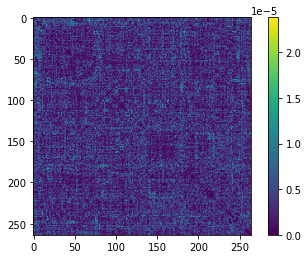

In [99]:
import matplotlib.pyplot as plt

def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

sn = [torch.mean(t[:,0,:]**2, axis=0) for t in finalRes]
se = [torch.mean(t[:,1,:]**2, axis=0) for t in finalRes]

plt.imshow(heatmap(sn[0]))
plt.colorbar()
plt.show()

In [143]:
nidcs = [torch.argsort(t) for t in sn]
eidcs = [torch.argsort(t) for t in se]

print(nidcs[2][-5:])
print(eidcs[2][-5:])

tensor([ 2540,  4394, 31926,  1969,  2409], device='cuda:0')
tensor([ 6729, 20055,  6619,  6572, 15912], device='cuda:0')


In [113]:
np.triu_indices(264,1)[0][15912]

69

In [86]:
with open('../../Work/LatentSim/Gcn/ProtectAgeSaliency.pkl', 'wb') as f:
    pickle.dump([t.detach().cpu().numpy() for t in finalRes], f)
    
print('Complete')

In [89]:
finalRes[0].shape

torch.Size([496, 2, 34716])

In [94]:
len(sn)

10

In [148]:
topRMSE

array([[36.05532837, 35.57883453, 34.61606598, 34.67256927, 34.48221207,
        34.14101028, 34.34934235, 34.51052094, 34.6151619 , 34.53464127],
       [42.85968399, 41.98724365, 42.27091599, 42.26716995, 40.58614731,
        40.45172501, 40.09013748, 40.02111435, 39.63227081, 39.4345932 ],
       [34.15948105, 33.58963394, 32.96852875, 32.50120926, 32.1470108 ,
        31.87003708, 31.93450356, 31.73294258, 31.49118042, 31.56783295],
       [38.65975571, 38.72233582, 38.64561844, 38.56875229, 38.37774658,
        37.93215561, 38.28313828, 37.91144943, 37.93764877, 37.86761475],
       [38.74171448, 38.21481705, 37.98765564, 37.57434082, 37.28759003,
        37.66639709, 37.25239563, 37.39114761, 37.24263763, 37.20225143],
       [37.32249069, 35.12443542, 34.96528625, 34.55741882, 34.41945267,
        34.03680038, 33.9756279 , 33.49002838, 33.32485199, 33.44581223],
       [37.62441635, 37.43936157, 36.96055984, 37.01319122, 36.9307251 ,
        36.70254135, 36.56831741, 36.71561813

In [37]:
with open('../../Work/LatentSim/Gcn/WratGcn.pkl', 'wb') as f:
    pickle.dump(topRMSE, f)
    
print('Complete')

Complete


In [131]:
with open('../../Work/LatentSim/Greed/Validation.pkl', 'rb') as f:
    topRegions, _ = pickle.load(f)
    
print('Complete')

Complete


In [140]:
nidcs = np.flip(topRegions[:,:,0,4,0], axis=1).astype('int')
eidcs = np.flip(topRegions[:,:,1,4,0], axis=1).astype('int')

print(nidcs)
print(eidcs)

[[22798 28718   706   458 20011  2648  6732  5594 16763 10372]
 [12350 19049   196 32438 13404 18793  6732  5583  2648 10372]
 [17366 33497  9498 31411 20109 32438  8850  5583  2648 10372]
 [33884 28641 19165   196  3409 18970  6732  5583  2648 10372]
 [19864 33856 26997 28718  2648 20011  6732  5583 16763 10372]
 [20011 16186  6871 28620   196  3323  8850  5583  2648 10372]
 [33170 28718  9943 15893  9498 20011  6675  5594  2648 10372]
 [15889 31628 31411 27769  3159 18793  6732  5583  2648 10372]
 [10543 14416  2061 24287 18970 16579  6732  5583  2648 10372]
 [14336 33884 34571 14416 18364 18970  6732  5583  2648 10372]]
[[ 9858  6717  2159 16763  5063 24432 31165  7248 17428 10372]
 [   44 27684 32772 21537 20672  6650 16780  8176 17428 10372]
 [10608 11797   257 30239 20672  5063 16780  8176 33816  6706]
 [ 9858 32424 33884  5063 20503  6650  1116  8176  2648 10372]
 [19858 18731 26094 20629 29350  6533   791 16780  8176 10372]
 [  166 20672 30239 20016 17428  5063 33290  6706  817